# Assignment 5: Text Classification with RNNs (Part 1) - Kai Ponel & Hannan Mahadik

# Imports

In [ ]:
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from matplotlib import pyplot as plt

from datetime import datetime
import time

# Dataset

In [ ]:
# remove infrequent words. you can play with this parameter as it will likely impact model quality
num_words = 2000
seq_len=200

(train_sequences, train_labels), (test_sequences, test_labels) = tf.keras.datasets.imdb.load_data(num_words=num_words)

In [ ]:
# padding all sequences to a predefined seq_len
train_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=seq_len, truncating='pre')
test_sequences = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=seq_len, truncating='pre')

## For low-level RNN

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((train_sequences, train_labels))
test_data = tf.data.Dataset.from_tensor_slices((test_sequences, test_labels))

In [ ]:
train_sequences.shape

(25000, 200)

# Explanatory Stuff from Exercise Notebook

In [ ]:
# look at some sequences. words have been replaced with arbitrary index mappings
# 1 is a special "beginning of sequence" marker
# infrequent words have been replaced by the index 2
# actual words start with index 4, 3 is never used (???)
train_sequences[:3]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 82

In [ ]:
# labels are simply binary: sentiment can be positive or negative
train_labels[:3]

array([1, 0, 0])

In [ ]:
# to restore words, load the word-to-index mapping
word_to_index = tf.keras.datasets.imdb.get_word_index()

1641221/1641221 [==============================] - 0s 0us/step


In [ ]:
# invert to get index-to-word mapping
index_to_word = dict((index, word) for (word, index) in word_to_index.items())

In [ ]:
# we can convert a sequence to text by
# - replacing each index by the respective word
# - joining words together via spaces
# note that we remove the beginning of sequence character and we have to subtract 3 from all indices
# this is because, as mentioned above, the smallest indices are reserved for special characters
# but for some reason this is not reflected in the mapping...
" ".join([index_to_word.get(index - 3, "UNKNOWN") for index in train_sequences[0][1:]])

"this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert UNKNOWN is an amazing actor and now the same being director UNKNOWN father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the UNKNOWN of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be pr

In [ ]:
# solution is padding all sequences to the maximum length.
# first find the maximum length
sequence_lengths = [len(sequence) for sequence in train_sequences]
max_len = max(sequence_lengths)
max_len

2494

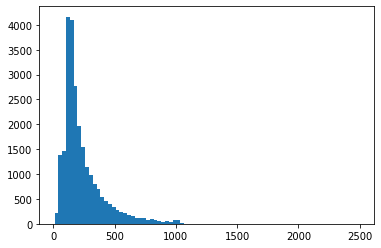

In [ ]:
# overview over sequence lengths in the data
# could also look at mean, median, standard deviation...
plt.hist(sequence_lengths, bins=80)
plt.show()

In [ ]:
# luckily there is a convenient function for padding
train_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_len)

In [ ]:
# now we can create a dataset!
train_data = tf.data.Dataset.from_tensor_slices((train_sequences_padded, train_labels))

In [ ]:
# all sequences are... very long
train_sequences_padded.shape

(25000, 2494)

In [ ]:
# it would be better to do something like this
# all sequences above maxlen will be truncated to that length
# note: pad_sequences has "pre" and "post" options for both padding and truncation. one may be better than the other!
train_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=200)
train_data = tf.data.Dataset.from_tensor_slices((train_sequences_padded, train_labels))

train_sequences_padded.shape

(25000, 200)

In [ ]:
# for fun, you can look at the word-index mappings.
# in this case, the mapping was done according to word frequency.
# you can pass reverse=True to sorted() to look at the least common words.
sorted(index_to_word.items())[:100]

[(1, 'the'),
 (2, 'and'),
 (3, 'a'),
 (4, 'of'),
 (5, 'to'),
 (6, 'is'),
 (7, 'br'),
 (8, 'in'),
 (9, 'it'),
 (10, 'i'),
 (11, 'this'),
 (12, 'that'),
 (13, 'was'),
 (14, 'as'),
 (15, 'for'),
 (16, 'with'),
 (17, 'movie'),
 (18, 'but'),
 (19, 'film'),
 (20, 'on'),
 (21, 'not'),
 (22, 'you'),
 (23, 'are'),
 (24, 'his'),
 (25, 'have'),
 (26, 'he'),
 (27, 'be'),
 (28, 'one'),
 (29, 'all'),
 (30, 'at'),
 (31, 'by'),
 (32, 'an'),
 (33, 'they'),
 (34, 'who'),
 (35, 'so'),
 (36, 'from'),
 (37, 'like'),
 (38, 'her'),
 (39, 'or'),
 (40, 'just'),
 (41, 'about'),
 (42, "it's"),
 (43, 'out'),
 (44, 'has'),
 (45, 'if'),
 (46, 'some'),
 (47, 'there'),
 (48, 'what'),
 (49, 'good'),
 (50, 'more'),
 (51, 'when'),
 (52, 'very'),
 (53, 'up'),
 (54, 'no'),
 (55, 'time'),
 (56, 'she'),
 (57, 'even'),
 (58, 'my'),
 (59, 'would'),
 (60, 'which'),
 (61, 'only'),
 (62, 'story'),
 (63, 'really'),
 (64, 'see'),
 (65, 'their'),
 (66, 'had'),
 (67, 'can'),
 (68, 'were'),
 (69, 'me'),
 (70, 'well'),
 (71, 'than'),


# RNN

## Many-to-One

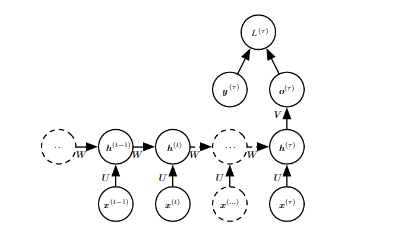

## Low-level Model

### Parameter initialization

In [ ]:
hidden_units = 100
optimizer = tf.optimizers.Adam()
loss_fn = tf.losses.BinaryCrossentropy(from_logits=True)
initializer = keras.initializers.HeNormal()
acc = tf.keras.metrics.BinaryAccuracy(threshold=0.5)

# Intitializing the weights
weights = {
  'W' : tf.Variable(initializer([hidden_units,hidden_units]),dtype=tf.dtypes.float32),
  'U' : tf.Variable(initializer([num_words,hidden_units]),dtype=tf.dtypes.float32), 
  'V' : tf.Variable(initializer([hidden_units, 1]),dtype=tf.dtypes.float32)
}
biases = {
  'b_h' : tf.Variable(tf.zeros([hidden_units]),dtype=tf.dtypes.float32)
}

all_trainable_variables = [weights['W'],weights['U'], weights["V"],biases['b_h']]

### RNN

In [ ]:
# training loop -- same thing as before!!
# our data is now slightly different (each batch of sequences has a time axis, which is kinda new)
# but all the related changes are hidden away at lower levels
def train_loop():
  for step, (sequences, labels) in enumerate(train_data):
      if step > 2000:
          break

      with tf.GradientTape() as tape:
          logits = rnn_loop(sequences)[0]
          loss = loss_fn(labels, logits)
      
      gradients = tape.gradient(loss, all_trainable_variables)

      optimizer.apply_gradients(zip(gradients,all_trainable_variables))
      acc(labels, logits)

      if not step % 200:
          print("Accuracy: {}".format(acc.result().numpy()))
          acc.reset_state()

# here's where things start to change
# we loop over the input time axis, and at each time step compute the new
# hidden state based on the previous one as well as the current input
# the state computation is hidden away in the rnn_step function and could be
# arbitrarily complex.
# in the general RNN, an output is computed at each time step, and the whole
# sequence is returned. but in this case, since we only have one label for the
# entire sequence, we only use the final state to compute one output and return it.
# before the loop, the state need to be initialized somehow.
def rnn_loop(sequences):

    old_state = tf.transpose(tf.zeros([hidden_units, 1]))

    for step in range(seq_len):
        x_t = sequences[step: step+1] # x_t = sequences[:, step]
        x_t = tf.one_hot(x_t, depth=num_words, axis=-1)
        new_state = rnn_step(old_state, x_t)

        old_state = new_state

    o_t = output_layer(old_state)

    return o_t


def rnn_step(state, x_t):

    new_state = tf.nn.tanh(tf.matmul(x_t, weights['U']) + tf.matmul(state, weights['W']) + biases['b_h'])
    return new_state


def output_layer(state):

    return (tf.nn.sigmoid(tf.matmul(state, weights['V'])))



train_loop()

Accuracy: 0.40789473056793213
Accuracy: 0.5600000023841858
Accuracy: 0.41999998688697815
Accuracy: 0.5
Accuracy: 0.5649999976158142
Accuracy: 0.550000011920929
Accuracy: 0.5450000166893005
Accuracy: 0.5550000071525574
Accuracy: 0.4050000011920929
Accuracy: 0.5299999713897705
Accuracy: 0.49000000953674316


### Test Accuracy

In [ ]:
test_acc_metric = tf.keras.metrics.BinaryAccuracy(threshold=0.5)

for _, (test_sequences, test_labels) in enumerate(test_data):
    test_acc_metric(test_labels, rnn_loop(test_sequences))

print("Test acc: {}".format(test_acc_metric.result()))

Test acc: 0.5018399953842163


## Model with custom Keras layer

### Rnn_layer

In [ ]:
class Rnn_layer(keras.layers.Layer):

  def __init__(self, initializer, regularizer, hidden_units, **kwargs):
    super(Rnn_layer, self).__init__(**kwargs)
    self.initializer = initializer
    self.regularizer = regularizer
    self.hidden_units = hidden_units


  def get_config(self):
      config = super().get_config().copy()
      config.update({
          'initializer': self.initializer,
          'regularizer': self.regularizer,
          'hidden_units': self.hidden_units
      })
      return config


  def build(self, input_shape):

    h_weight = (self.hidden_units, self.hidden_units)
    self.W = tf.Variable(self.initializer(shape=h_weight))

    i_weight = (num_words, self.hidden_units)
    self.U = tf.Variable(self.initializer(shape=i_weight))

    bias = (1, self.hidden_units)
    self.b = tf.Variable(tf.zeros(bias))

    self.activation = keras.activations.relu


  @tf.function
  def call(self, sequences):

    h = tf.zeros((1, self.hidden_units))

    for step in range(seq_len):
      x_t = sequences[:, step]
      x_t = tf.one_hot(x_t, depth=num_words)
      h = self.activation(h @ self.W + x_t @ self.U + self.b)

    return h

### Model Architecture

In [ ]:
optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [keras.metrics.BinaryAccuracy()]

In [ ]:
hidden_units = 100
initializer = keras.initializers.HeNormal()
regularizer = keras.regularizers.L2(1e-4)

In [ ]:
model = tf.keras.models.Sequential([
  Rnn_layer(hidden_units=hidden_units, initializer=initializer, regularizer=regularizer),
  tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

### Train

In [ ]:
rnn_model1 = model.fit(train_sequences, train_labels, batch_size = 100, epochs = 5, validation_data = (test_sequences, test_labels))

Epoch 1/5
250/250 [==============================] - 307s 1s/step - loss: 6.9022 - binary_accuracy: 0.5020 - val_loss: 0.6817 - val_binary_accuracy: 0.5156
Epoch 2/5
250/250 [==============================] - 282s 1s/step - loss: 0.6597 - binary_accuracy: 0.5335 - val_loss: 0.6527 - val_binary_accuracy: 0.5471
Epoch 3/5
250/250 [==============================] - 253s 1s/step - loss: 0.5943 - binary_accuracy: 0.6279 - val_loss: 0.5931 - val_binary_accuracy: 0.6044
Epoch 4/5
250/250 [==============================] - 281s 1s/step - loss: 0.5087 - binary_accuracy: 0.7288 - val_loss: 0.5152 - val_binary_accuracy: 0.7517
Epoch 5/5
250/250 [==============================] - 270s 1s/step - loss: 0.4037 - binary_accuracy: 0.8090 - val_loss: 0.4534 - val_binary_accuracy: 0.8099


### Evaluation

782/782 - 70s - loss: 0.4534 - binary_accuracy: 0.8099 - 70s/epoch - 90ms/step


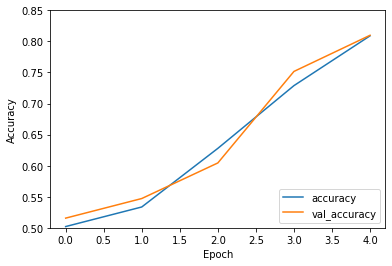

In [ ]:
plt.plot(rnn_model1.history['binary_accuracy'], label='accuracy')
plt.plot(rnn_model1.history['val_binary_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 0.85])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_sequences, test_labels, verbose=2)

## Experimental Keras Model

### Rnn_layer

In [ ]:
class Rnn_layer2(keras.layers.Layer):

  def __init__(self, initializer, regularizer, hidden_units, **kwargs):
    super(Rnn_layer2, self).__init__(**kwargs)
    self.initializer = initializer
    self.regularizer = regularizer
    self.hidden_units = hidden_units


  def get_config(self):
      config = super().get_config().copy()
      config.update({
          'initializer': self.initializer,
          'regularizer': self.regularizer,
          'hidden_units': self.hidden_units
      })
      return config


  def build(self, input_shape):

    h_weight = (self.hidden_units, self.hidden_units)
    self.W = tf.Variable(self.initializer(shape=h_weight))

    i_weight = (num_words, self.hidden_units)
    self.U = tf.Variable(self.initializer(shape=i_weight))

    bias = (1, self.hidden_units)
    self.b = tf.Variable(tf.zeros(bias))

    v_weight = (self.hidden_units, 1)
    self.V = tf.Variable(self.initializer(shape=v_weight))

    self.activation = keras.activations.relu
    self.output_activation = keras.activations.sigmoid


  @tf.function
  def call(self, sequences):

    h = tf.zeros((1, self.hidden_units))

    for step in range(seq_len):
      x_t = sequences[:, step]
      x_t = tf.one_hot(x_t, depth=num_words)
      h = self.activation(h @ self.W + x_t @ self.U + self.b)

    h = self.output_activation(h @ self.V)
    
    return h

### Model Architecture

In [ ]:
hidden_units = 100
initializer = keras.initializers.HeNormal()
regularizer = keras.regularizers.L2(1e-4)

In [ ]:
model2 = tf.keras.models.Sequential([
  Rnn_layer2(hidden_units=hidden_units, initializer=initializer, regularizer=regularizer)
])

In [ ]:
model2.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

### Train

In [ ]:
rnn_model2 = model2.fit(train_sequences, train_labels, batch_size = 100, epochs = 5, validation_data = (test_sequences, test_labels))

Epoch 1/5
250/250 [==============================] - 344s 1s/step - loss: 0.6931 - binary_accuracy: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 2/5
250/250 [==============================] - 320s 1s/step - loss: 0.6931 - binary_accuracy: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 3/5
250/250 [==============================] - 334s 1s/step - loss: 0.6931 - binary_accuracy: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 4/5
122/250 [=============>................] - ETA: 2:28 - loss: 0.6931 - binary_accuracy: 0.5006

KeyboardInterrupt: ignored

# Food for Thought Questions

## Extra
You may sometimes get a higher test accuracy, while the test loss is also increasing (how can this be?)!

If the loss increases and the accuracy increase too is because your regularization techniques are working well and you're fighting the overfitting problem.

## Question 1:
All sequences are padded to the length of the longest sequence in the dataset. Why is this wasteful? Can you think of a smarter padding scheme that is more efficient? Consider the fact that RNNs can work on arbitrary sequence lengths, and that training minibatches are pretty much independent of each other.

There can be extremely short sequences that may need to be padded with a lot of 0s to ensure every sequence has the same length. Maybe we can create batches out of sequences and then pad them according to the longest sequence in that particular batch.

## Question 2:
Between truncating long sequences and removing them, which option do you think is better? Why?

I think it is better to truncate long sequences as it could be possible that certain long sequences are necessary to train the model to classify a certain output. 

## Question 3:
Can you think of a way to avoid the one-hot vectors completely? Even if you cannot implement it, a conceptual idea is fine.

a one-hot is a group of bits among which the legal combinations of values are only those with a single high (1) bit and all the others low (0)
-> Instead, use word vectors to generate word embeddings, which are "..a real number, vector representation of a word... words with similar meaning will have vector representations that are close together in the embedding space" 

## Question 4:
For the output and loss, you actually have two options:

1.   You could have an output layer with 2 units, and use sparse categorical cross-entropy as before (i.e. softmax activation). Here, whichever output is higher “wins”.
2.   You can have a single output unit and use binary cross-entropy (i.e. sigmoid activation). Here, the output is usually thresholded at 0.5.

How can it be that we can choose how many outputs we have, i.e. how can both be correct? Are there differences between both choices as well as (dis)advantages relative to each other?

Using categorical cross-entropy we provide a classification, let's say 1 or 0, based on the outputs of both output units. The higher value is considered as the prediction. We do the same thing in binary cross-entropy by having just one output unit and providing a threshold. Any value above the threshold can be classified as 1, and anything below as 0. So these two methods technically do the same thing. 

---
(Dis)Advantages?

## Question 5:
All sequences start with the same special “beginning of sequence” token (coded by index 1). Given this fact, is there a point in learning an initial state? Why (not)?

"If there are enough sequences or state resets in the training data (e.g., this will often be the case if we are doing sequence classification), it may make sense to train the initial state as a variable. This way, the model can learn a good default state. If we have only a few state resets, however, training the initial state as a variable may result in overfitting on the start of each sequence."

## Question 6:
pad_sequences allows for pre or post padding. Try both to see the difference. Which option do you think is better? Recall that we use the final time step output from our model.

Pre padding provided better results.
Since we use the final time step output, by pre-padding the sequences, all the zeros would appear at the start, i.e., further away from the output. This ensures that the actual information is closer to the output. (short/long term dependencies?)

## Question 7:
Can you think of a way to prevent the RNN from computing new states on padded time steps? One idea might be to “pass through” the previous state in case the current time step is padding. Note that, within a batch, some sequences might be padded for a given time step while others are not.

We can use the mask parameter, as seen in the Keras RNN layer - "mask: Binary tensor of shape [batch_size, timesteps] indicating whether a given timestep should be masked. An individual True entry indicates that the corresponding timestep should be utilized, while a False entry indicates that the corresponding timestep should be ignored."

## Question 8:


*  Instead of only using the final output, average (or sum?) the logits (pre-sigmoid) of all time steps and use this as the output instead.
*  Instead of the logits, average the states at all time steps and compute the output based on this average state. Is this different from the above option?
*  Compute logits and sigmoids for each output, and average the per-step probabilities.


What could be the advantage of using methods like the above? What are disadvantages? Can you think of other methods to incorporate the full output sequence instead of just the final step?